<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 64, '日付': '2021-12-30T08:00:00.000Z'},
 {'小計': 78, '日付': '2021-12-31T08:00:00.000Z'},
 {'小計': 79, '日付': '2022-01-01T08:00:00.000Z'},
 {'小計': 84, '日付': '2022-01-02T08:00:00.000Z'},
 {'小計': 103, '日付': '2022-01-03T08:00:00.000Z'},
 {'小計': 151, '日付': '2022-01-04T08:00:00.000Z'},
 {'小計': 390, '日付': '2022-01-05T08:00:00.000Z'},
 {'小計': 641, '日付': '2022-01-06T08:00:00.000Z'},
 {'小計': 922, '日付': '2022-01-07T08:00:00.000Z'},
 {'小計': 1224, '日付': '2022-01-08T08:00:00.000Z'},
 {'小計': 1223, '日付': '2022-01-09T08:00:00.000Z'},
 {'小計': 871, '日付': '2022-01-10T08:00:00.000Z'},
 {'小計': 962, '日付': '2022-01-11T08:00:00.000Z'},
 {'小計': 2198, '日付': '2022-01-12T08:00:00.000Z'},
 {'小計': 3124, '日付': '2022-01-13T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2022-01-09 17:00:00+09:00,597,0,1223,2022-01-09 17:00:00+09:00
2022-01-10 17:00:00+09:00,727,0,871,2022-01-10 17:00:00+09:00
2022-01-11 17:00:00+09:00,815,0,962,2022-01-11 17:00:00+09:00
2022-01-12 17:00:00+09:00,964,0,2198,2022-01-12 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2022-01-09 17:00:00+09:00,597,0,1223,2022-01-09 17:00:00+09:00,405.285714,2837.0,0.0,0.0,664.857143,4654.0
2022-01-10 17:00:00+09:00,727,0,871,2022-01-10 17:00:00+09:00,483.428571,3384.0,0.0,0.0,774.571429,5422.0
2022-01-11 17:00:00+09:00,815,0,962,2022-01-11 17:00:00+09:00,561.428571,3930.0,0.0,0.0,890.428571,6233.0
2022-01-12 17:00:00+09:00,964,0,2198,2022-01-12 17:00:00+09:00,652.285714,4566.0,0.0,0.0,1148.714286,8041.0
2022-01-13 17:00:00+09:00,0,0,3124,2022-01-13 17:00:00+09:00,601.285714,4209.0,0.0,0.0,1503.428571,10524.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2021-12-30 17:00:00+09:00,236,0,64,2021-12-30 17:00:00+09:00,176.857143,1238.0,0.0,0.0,48.714286,341.0,'21w52,Thu
2021-12-31 17:00:00+09:00,157,0,78,2021-12-31 17:00:00+09:00,175.285714,1227.0,0.0,0.0,54.285714,380.0,'21w52,Fri
2022-01-01 17:00:00+09:00,131,0,79,2022-01-01 17:00:00+09:00,167.142857,1170.0,0.0,0.0,60.142857,421.0,'22w52,Sat
2022-01-02 17:00:00+09:00,145,0,84,2022-01-02 17:00:00+09:00,170.857143,1196.0,0.0,0.0,66.000000,462.0,'22w52,Sun
2022-01-03 17:00:00+09:00,180,0,103,2022-01-03 17:00:00+09:00,173.142857,1212.0,0.0,0.0,75.714286,530.0,'22w01,Mon
2022-01-04 17:00:00+09:00,269,0,151,2022-01-04 17:00:00+09:00,192.714286,1349.0,0.0,0.0,90.714286,635.0,'22w01,Tue
2022-01-05 17:00:00+09:00,328,0,390,2022-01-05 17:00:00+09:00,206.571429,1446.0,0.0,0.0,135.571429,949.0,'22w01,Wed
2022-01-06 17:00:00+09:00,357,0,641,2022-01-06 17:00:00+09:00,223.857143,1567.0,0.0,0.0,218.000000,1526.0,'22w01,Thu
2022-01-07 17:00:00+09:00,443,0,922,2022-01-07 17:00:00+09:00,264.714286,1853.0,0.0,0.0,338.571429,2370.0,'22w01,Fri
2022-01-08 17:00:00+09:00,663,0,1224,2022-01-08 17:00:00+09:00,340.714286,2385.0,0.0,0.0,502.142857,3515.0,'22w01,Sat


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2021-12-31 17:00:00+09:00,59.800000,299
2021-01-03 17:00:00+09:00,816.000000,2448
2022-01-09 17:00:00+09:00,664.857143,4654
2022-01-13 17:00:00+09:00,1788.750000,7155
2022-01-02 17:00:00+09:00,81.500000,163


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2021-12-30 17:00:00+09:00,236,0,64,2021-12-30 17:00:00+09:00,176.857143,1238.0,0.0,0.0,48.714286,341.0,'21w52,Thu,NaN,NaN
2021-12-31 17:00:00+09:00,157,0,78,2021-12-31 17:00:00+09:00,175.285714,1227.0,0.0,0.0,54.285714,380.0,'21w52,Fri,59.800000,299.0
2022-01-01 17:00:00+09:00,131,0,79,2022-01-01 17:00:00+09:00,167.142857,1170.0,0.0,0.0,60.142857,421.0,'22w52,Sat,NaN,NaN
2022-01-02 17:00:00+09:00,145,0,84,2022-01-02 17:00:00+09:00,170.857143,1196.0,0.0,0.0,66.000000,462.0,'22w52,Sun,81.500000,163.0
2022-01-03 17:00:00+09:00,180,0,103,2022-01-03 17:00:00+09:00,173.142857,1212.0,0.0,0.0,75.714286,530.0,'22w01,Mon,NaN,NaN
2022-01-04 17:00:00+09:00,269,0,151,2022-01-04 17:00:00+09:00,192.714286,1349.0,0.0,0.0,90.714286,635.0,'22w01,Tue,NaN,NaN
2022-01-05 17:00:00+09:00,328,0,390,2022-01-05 17:00:00+09:00,206.571429,1446.0,0.0,0.0,135.571429,949.0,'22w01,Wed,NaN,NaN
2022-01-06 17:00:00+09:00,357,0,641,2022-01-06 17:00:00+09:00,223.857143,1567.0,0.0,0.0,218.000000,1526.0,'22w01,Thu,NaN,NaN
2022-01-07 17:00:00+09:00,443,0,922,2022-01-07 17:00:00+09:00,264.714286,1853.0,0.0,0.0,338.571429,2370.0,'22w01,Fri,NaN,NaN
2022-01-08 17:00:00+09:00,663,0,1224,2022-01-08 17:00:00+09:00,340.714286,2385.0,0.0,0.0,502.142857,3515.0,'22w01,Sat,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

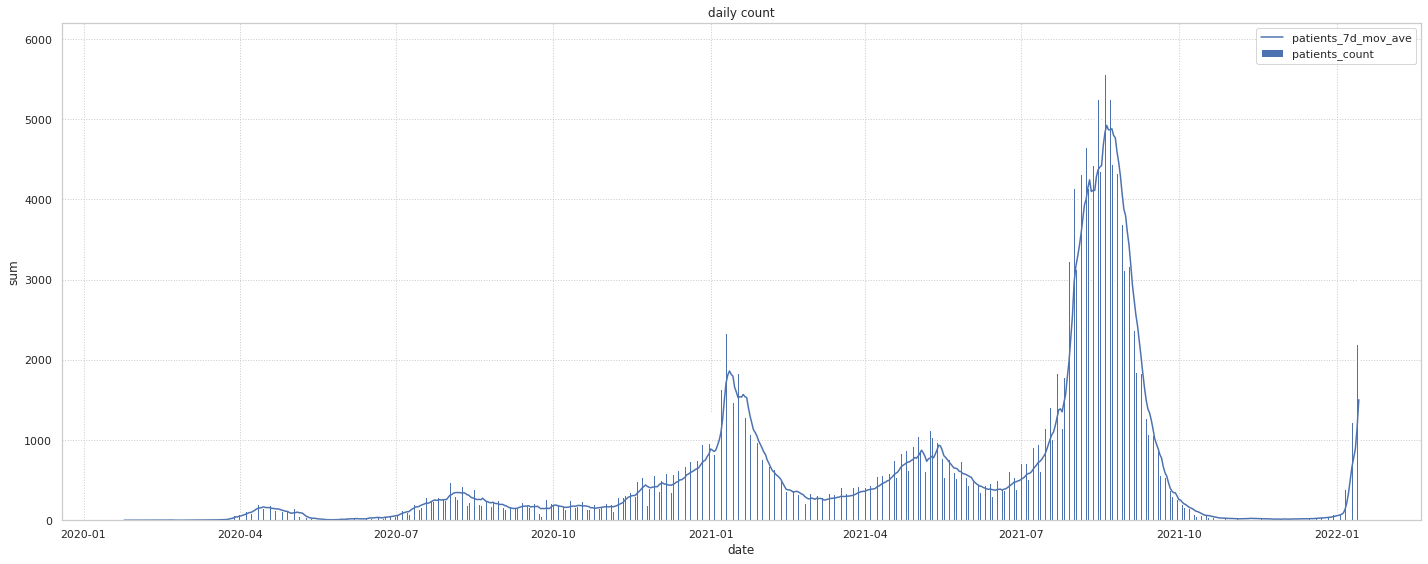

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
706,1.640851e+09,2021,12,30,0,0,0,0,1,0,0,706,0,632,236,176.857143,1238.0,0,0.0,0.0,64,48.714286,341.0
707,1.640938e+09,2021,12,31,1,0,0,0,0,0,0,707,0,633,157,175.285714,1227.0,0,0.0,0.0,78,54.285714,380.0
708,1.641024e+09,2022,1,1,0,0,1,0,0,0,0,708,0,634,131,167.142857,1170.0,0,0.0,0.0,79,60.142857,421.0
709,1.641110e+09,2022,1,2,0,0,0,1,0,0,0,709,0,635,145,170.857143,1196.0,0,0.0,0.0,84,66.000000,462.0
710,1.641197e+09,2022,1,3,0,1,0,0,0,0,0,710,0,636,180,173.142857,1212.0,0,0.0,0.0,103,75.714286,530.0
711,1.641283e+09,2022,1,4,0,0,0,0,0,1,0,711,0,637,269,192.714286,1349.0,0,0.0,0.0,151,90.714286,635.0
712,1.641370e+09,2022,1,5,0,0,0,0,0,0,1,712,0,638,328,206.571429,1446.0,0,0.0,0.0,390,135.571429,949.0
713,1.641456e+09,2022,1,6,0,0,0,0,1,0,0,713,0,639,357,223.857143,1567.0,0,0.0,0.0,641,218.000000,1526.0
714,1.641542e+09,2022,1,7,1,0,0,0,0,0,0,714,0,640,443,264.714286,1853.0,0,0.0,0.0,922,338.571429,2370.0
715,1.641629e+09,2022,1,8,0,0,1,0,0,0,0,715,0,641,663,340.714286,2385.0,0,0.0,0.0,1224,502.142857,3515.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 721 entries, 0 to 720
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            721 non-null    float64
 1   year                 721 non-null    int64  
 2   month                721 non-null    int64  
 3   day                  721 non-null    int64  
 4   Fri                  721 non-null    uint8  
 5   Mon                  721 non-null    uint8  
 6   Sat                  721 non-null    uint8  
 7   Sun                  721 non-null    uint8  
 8   Thu                  721 non-null    uint8  
 9   Tue                  721 non-null    uint8  
 10  Wed                  721 non-null    uint8  
 11  passed               721 non-null    int64  
 12  emergency            721 non-null    int64  
 13  em_passed            721 non-null    int64  
 14  contacts_count       721 non-null    int64  
 15  contacts_7d_mov_ave  721 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,7.210000e+02,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.00000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000
mean,1.610957e+09,2020.542302,6.596394,15.700416,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,360.00000,0.067961,289.848821,613.647712,611.247441,4278.726768,511.122053,511.122053,3577.854369,547.919556,540.024034,3780.145631
std,1.799531e+07,0.533541,3.413525,8.858399,0.350170,0.350170,0.350170,0.350170,0.350170,0.350170,0.350170,208.27906,0.251854,202.408808,473.335670,462.729259,3239.111802,800.369702,733.309283,5133.164981,954.112970,916.685743,6416.813524
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.595405e+09,2020.000000,4.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.00000,0.000000,106.000000,311.000000,303.857143,2127.000000,0.000000,0.000000,0.000000,41.000000,41.857143,293.000000
50%,1.610957e+09,2021.000000,7.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,360.00000,0.000000,286.000000,491.000000,484.285714,3390.000000,0.000000,0.000000,0.000000,236.000000,250.285714,1752.000000
75%,1.626509e+09,2021.000000,10.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,540.00000,0.000000,466.000000,754.000000,736.714286,5157.000000,1064.000000,1067.714286,7474.000000,563.000000,569.000000,3983.000000
max,1.642061e+09,2022.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,720.00000,1.000000,646.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,5908.000000,4923.428571,34464.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.867750,0.377665,-0.009566,-5.884389e-03,-7.595057e-18,-3.922926e-03,-1.961463e-03,5.884389e-03,1.961463e-03,3.922926e-03,1.000000e+00,-3.399151e-01,0.998314,-0.315099,-0.312238,-0.312235,-0.616546,-6.628746e-01,-6.628746e-01,0.338669,0.346075,0.346080
year,8.677502e-01,1.000000,-0.130549,-0.064316,-6.371969e-03,1.061995e-03,1.061995e-03,1.061995e-03,1.061995e-03,1.061995e-03,1.061995e-03,8.677502e-01,-2.746554e-01,0.873563,-0.269025,-0.265900,-0.265897,-0.649995,-7.094367e-01,-7.094367e-01,0.361434,0.361369,0.361372
month,3.776651e-01,-0.130549,1.000000,0.016435,-4.979763e-04,-1.659921e-03,-9.793533e-03,-6.307699e-03,9.959525e-03,1.825913e-03,6.473692e-03,3.776651e-01,-1.651450e-01,0.363300,-0.125115,-0.125484,-0.125481,-0.016889,2.645425e-03,2.645425e-03,0.001058,0.015744,0.015749
day,-9.566297e-03,-0.064316,0.016435,1.000000,7.995493e-03,-3.645945e-03,-9.594592e-04,4.413512e-03,-1.854954e-03,1.279279e-03,-7.227926e-03,-9.566297e-03,-1.994528e-04,-0.009087,-0.009147,-0.007363,-0.007366,0.009579,-1.109192e-03,-1.109192e-03,0.002074,0.004088,0.004084
Fri,-5.884389e-03,-0.006372,-0.000498,0.007995,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-5.884389e-03,-8.742185e-18,-0.005417,-0.015215,-0.002492,-0.002492,0.027040,4.611825e-18,-2.020418e-18,0.024923,-0.002413,-0.002415
Mon,-7.595057e-18,0.001062,-0.001660,-0.003646,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,5.141818e-18,1.185659e-17,-0.000008,0.032012,-0.000059,-0.000059,0.106915,7.071465e-18,-1.484568e-17,-0.089135,-0.000365,-0.000364
Sat,-3.922926e-03,0.001062,-0.009794,-0.000959,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-3.922926e-03,-9.616403e-18,-0.003614,0.041213,-0.001681,-0.001680,-0.123413,3.074550e-18,-2.020418e-18,0.026868,-0.001657,-0.001658
Sun,-1.961463e-03,0.001062,-0.006308,0.004414,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.961463e-03,1.092773e-17,-0.001811,-0.024055,-0.000949,-0.000949,-0.113705,3.074550e-19,-5.182813e-18,-0.023096,-0.000902,-0.000902
Thu,5.884389e-03,0.001062,0.009960,-0.001855,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,5.884389e-03,-8.523630e-18,0.005439,-0.009215,0.002119,0.002120,0.031193,-2.152185e-18,-5.270657e-18,0.057036,0.003519,0.003520
Tue,1.961463e-03,0.001062,0.001826,0.001279,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,1.961463e-03,1.486171e-17,0.001794,-0.016975,0.000939,0.000939,0.042655,1.844730e-18,-1.581197e-18,-0.020643,0.000230,0.000231


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,1.641715e+09,0,0,0,1,0,0,0,716,0,642,597,0,1223,664.857143,4654.0
717,1.641802e+09,0,1,0,0,0,0,0,717,0,643,727,0,871,774.571429,5422.0
718,1.641888e+09,0,0,0,0,0,1,0,718,0,644,815,0,962,890.428571,6233.0
719,1.641974e+09,0,0,0,0,0,0,1,719,0,645,964,0,2198,1148.714286,8041.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
716,1.641715e+09,716,0,1223,664.857143,4654.0
717,1.641802e+09,717,0,871,774.571429,5422.0
718,1.641888e+09,718,0,962,890.428571,6233.0
719,1.641974e+09,719,0,2198,1148.714286,8041.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

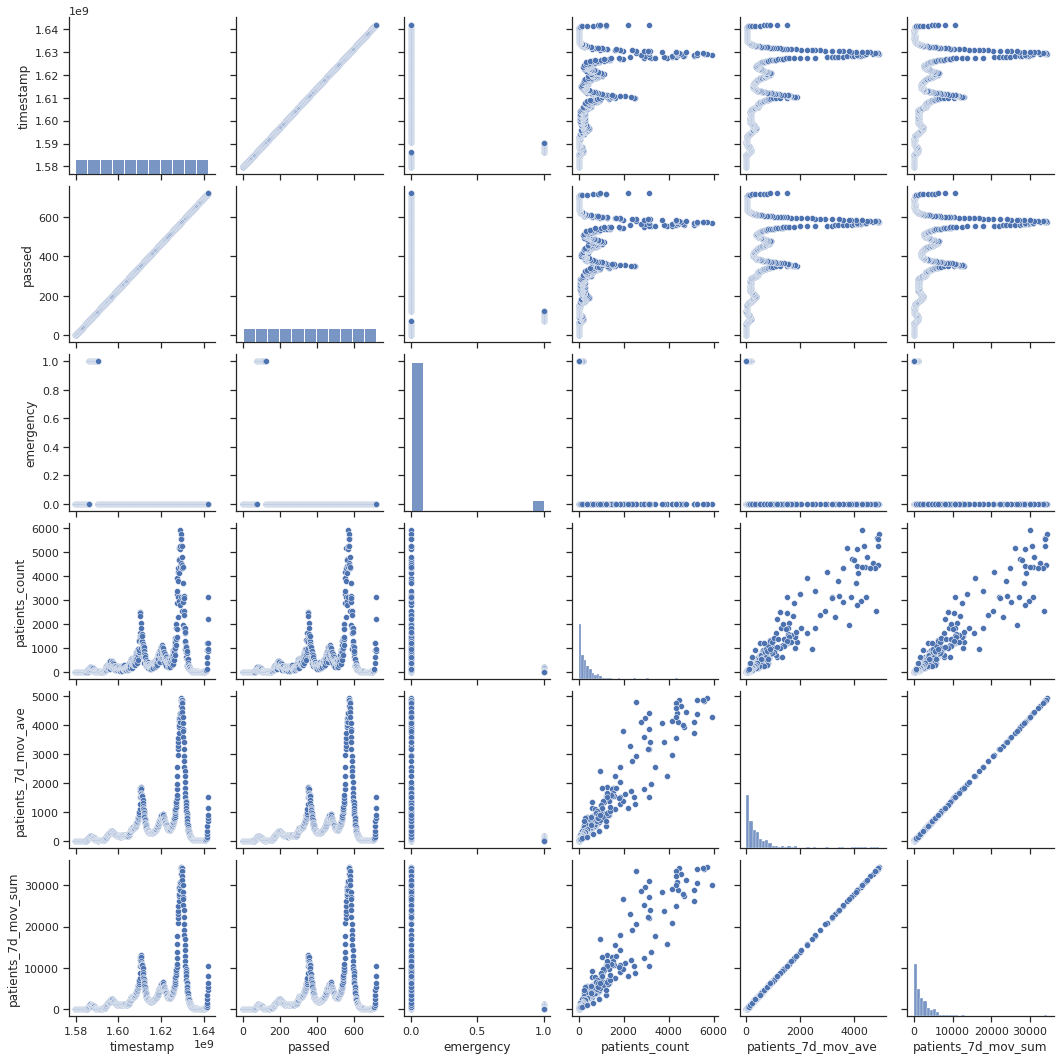

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.12
